In [39]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
# from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import math


''' Device config'''
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

''' Parameters (CHange Anything Here!) '''
torch.manual_seed(10)
transform = transforms.ToTensor()
batch_size = 100
# lifetime Sparcity
k_rate = 0.1

''' Code Starts Here '''
# Data MNIST
mnist_data = datasets.MNIST(root='./data', train = True, download = True, transform = transform)
data_loader = torch.utils.data.DataLoader(dataset= mnist_data, batch_size = batch_size, shuffle = True)
dataiter = iter(data_loader)


''' Conv 2d Layer 
#         Accessible Variables: .weights(Tensor), .bias(Tensor)
#         parameters :
#         torch.nn.Conv2d(in_channels, out_channels, 
#                         kernel_size, stride=1, padding=0, 
#                         dilation=1, groups=1, bias=True, 
#                         padding_mode='zeros')
'''
# CONV-WTA CRITERIA
# - zero padded, so that each feature map has the same size as the input
# - hidden representation is mapped linearly to the output using a deconvolution operation
# - Parameters are optimized to reduce the mean squared error MSE
# - Conv layer is 5 x5, DECONVOLUTION layer is using filters of 11x 11
### In this implementation, I will not use deconvolution, but transpose convolution to ease process
class Competitive_Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        #Image size:N, 28, 28
        self.conv1      = nn.Conv2d(1, 128, 5, stride=1, padding = 2)  # size:N, 28, 28
        self.conv2      = nn.Conv2d(128, 128, 5, stride=1, padding = 2)  # size:N, 28, 28
        self.conv3      = nn.Conv2d(128, 16, 5, stride=1, padding = 2)  # size:N, 28, 28
        self.transConv1 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=11, stride =1, padding = 5) # padding will decrease output size # size:N, 28, 28
        
    def forward(self, x):
        encoded = F.relu(self.conv1(x)) # encode, output: torch.Size([num_batches, num_channels, 28, 28])
        encoded = F.relu(self.conv2(encoded))
        encoded = F.relu(self.conv3(encoded))
        winner = self.spatial_sparsity_(encoded)
#         self.lifetime_sparsity_(encoded, winner, k_rate)
        decoded = self.transConv1(encoded)
        return decoded

#     def reconstruct(self, x):
#         encoded = nn.ReLU(self.conv1(x)) # encode, output: torch.Size([3, 2, 28, 28])
#         decoded = torch.sigmoid(self.transConv1(hidden))
#         return decoded
    
    # Spatial Sparsity reconstructs the activation map, remain only one winner neuron of each feature map and rest to 0
    # with torch.no_grad() temporarily sets all of the requires_grad flags to false
    def spatial_sparsity_(self, hiddenMaps):
        with torch.no_grad():
            shape = hiddenMaps.shape  #torch.Size([batch_size, feature_num, 26, 26])
            n_batches = shape[0]
            n_features = shape[1]
            size = shape[2]
            
            # Step 1: flatten it out, find max_vals
            flatten = hiddenMaps.view(n_batches, n_features, -1)
            maxval, _ = torch.max(flatten, 2) # max_val return size[n_batches, n_features]
            
            # Step 2: creating "drop" Array to be multiplied into featureMaps, dropping loser values
            maxval_p = torch.reshape(maxval, (n_batches, n_features, 1, 1))
            drop = torch.where(hiddenMaps < maxval_p, 
                               torch.zeros((n_batches, n_features, size, size)).to(device), 
                               torch.ones((n_batches,n_features, size, size)).to(device))
        
        # To retain the graph, use .data to only modify the data of the tensor
        hiddenMaps.data = hiddenMaps.data*drop.data
        return maxval
        
    # Only retain the top-k percent of the winners for every feature. The rest will be zeroed out
    def lifetime_sparsity_(self, hiddenMaps, maxval, k_percent):
        with torch.no_grad():
            shape = hiddenMaps.shape  #torch.Size([batch_size, feature_num, 26, 26])
            n_batches = shape[0]
            n_features = shape[1]
            size = shape[2]
            k = math.floor(n_batches * k_percent)
            
            top_k, _ = torch.topk(maxval, k, 0) 

            # Step 2: creating "drop" Array to be multiplied into featureMaps, dropping loser values
            drop = torch.where(maxval < top_k[k-1:k, :],  
                               torch.zeros((n_batches, n_features)).to(device), 
                               torch.ones((n_batches, n_features)).to(device))

        # To retain the graph, use .data to only modify the data of the tensor
        hiddenMaps.data = hiddenMaps.data * drop.reshape(n_batches, n_features, 1, 1).data
#         return hiddenMaps
    
#     def plot(self, tensors):
#         with torch.no_grad():
#             for i, item in enumerate(tensors):
#                 if i >= 9:
#                     break
#                 plt.subplot(2, 9, i + 1)
#                 plt.imshow(item[0])

#     def plot_filter(self):
#         with torch.no_grad():
#             for i, item in enumerate(tensors):
#                 if i >= 9:
#                     break
#                 plt.subplot(2, 9, i + 1)
#                 plt.imshow(item[0])
        
# Saving the state dicts of the model
def save_model_optimizer(model, optimizer = None, filename = "CompAutoModel", path = ""):
    temp_device = torch.device('cpu')
    if optimizer == None:
        torch.save({
            'model_state': model.state_dict()
        }, path+filename+".pth")
    else:
        torch.save({
            'model_state': model.state_dict(),
            'optim_state': optimizer.state_dict()
        }, path+filename+".pth")
    
def load_model(filename, path = ""):
    checkpoint = torch.load(path+filename+".pth", map_location = 'cpu')
    model_obj = Competitive_Autoencoder()
    model_obj.load_state_dict(checkpoint['model_state'])
    model_obj.eval()
        
    if len(checkpoint.keys()) == 1:
        return model_obj
    else:
        optim_obj = torch.optim.Adam(model_obj.parameters(), lr = 0)
        optim_obj.load_state_dict(checkpoint['optim_state'])
        return model_obj, optim_obj

In [40]:
model = Competitive_Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [41]:
# Training Loop
num_epochs = 20
outputs = []

for epoch in range(num_epochs):
    for (img, _) in data_loader:
        #Reconstructed img, Likely going to be 
        img = img.to(device)
        
        #Forward Pass
        recon  = model(img)
        loss = criterion(recon, img)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    if((epoch+1)%4 == 0):
        outputs.append((epoch, img, recon, ))

Epoch:1, Loss:0.0592
Epoch:2, Loss:0.0717
Epoch:3, Loss:0.0596
Epoch:4, Loss:0.0651
Epoch:5, Loss:0.0639
Epoch:6, Loss:0.0573
Epoch:7, Loss:0.0652
Epoch:8, Loss:0.0949
Epoch:9, Loss:0.0493
Epoch:10, Loss:0.0590
Epoch:11, Loss:0.0526
Epoch:12, Loss:0.0378
Epoch:13, Loss:0.0368
Epoch:14, Loss:0.0480
Epoch:15, Loss:0.0666
Epoch:16, Loss:0.0567
Epoch:17, Loss:0.0579
Epoch:18, Loss:0.0514
Epoch:19, Loss:0.1348
Epoch:20, Loss:0.0372


In [45]:
# Saving testing (DONE)
save_model_optimizer(model, optimizer, "128features")

# model_load, optim_load = load_model("test_save")

IndexError: list index out of range

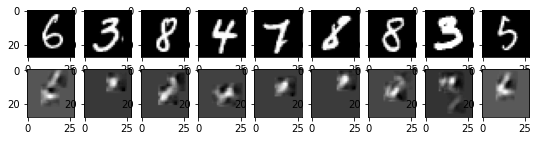

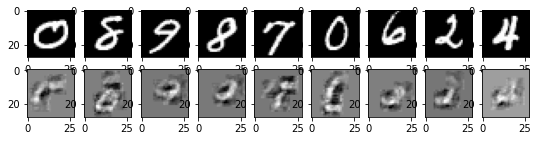

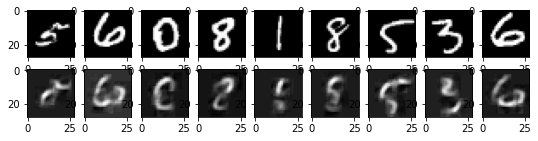

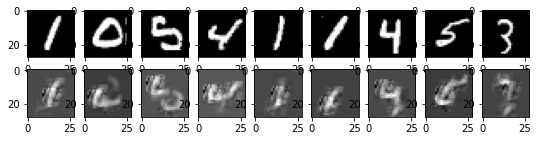

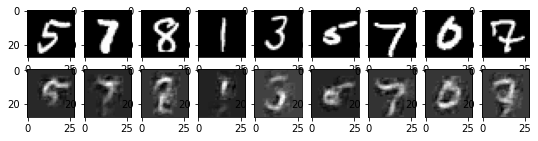

<Figure size 648x144 with 0 Axes>

In [42]:
##### Plotting the images for convolutional Autoencoder

for k in range(0, num_epochs, 1):
    plt.figure(figsize = (9,2))
    plt.gray()
    
    #because it is a Tensor, so we want to detach and then convert into a numpy array
    imgs = outputs[k][1].cpu().detach().numpy()
    recon = outputs[k][2].cpu().detach().numpy()
        
    for i, item in enumerate(imgs):
        if i >= 9:
            break
        plt.subplot(2, 9, i + 1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9 :
            break
        plt.subplot(2, 9, 9 + i + 1)
        plt.imshow(item[0])

ConvTranspose2d(16, 1, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
torch.Size([16, 1, 11, 11])
torch.Size([16, 1, 11, 11])
torch.Size([3, 28, 158])


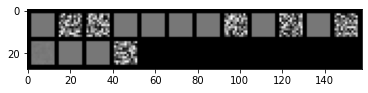

In [44]:
# Filter Plotting Testing
# gen = model.parameters()
# print(gen)

# next(gen)

# with torch.no_grad():
#     for i, item in enumerate(tensors):
#         if i >= 9:
#             break
#         plt.subplot(2, 9, i + 1)
#         plt.imshow(item[0])
        
children = list(model.children())
count = 0
while(not isinstance(children[count], nn.ConvTranspose2d)):
    count +=1
    
# printing the layer type
print(children[count])
kernels = children[count].weight.detach().clone().cpu()
print(kernels.shape)
# normalize to (0,1) range so that matplotlib
# can plot them
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
print(kernels.shape)
filter_img = torchvision.utils.make_grid(kernels, nrow = 12)
# change ordering since matplotlib requires images to 
# be (H, W, C)
print(filter_img.shape)
plt.imshow(filter_img.permute(1, 2, 0))

# # You can directly save the image as well using
# img = save_image(kernels, 'encoder_conv1_filters.png' ,nrow = 12)